In [124]:
import os
import json
import requests
import os
from typing import List
from operator import itemgetter
from collections import OrderedDict
from pprint import pprint

# Output Parser
from langchain_core.output_parsers import StrOutputParser

# Citation prompt from prompts.py
# from prompts import DOCSEARCH_PROMPT

# Lang Chain core libraries
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_openai import AzureChatOpenAI


### Search
# from langchain_community.tools.tavily_search.tool import TavilySearchAPIWrapper
from langchain_community.retrievers import TavilySearchAPIRetriever
from azure.cognitiveservices.search.websearch import WebSearchClient
from azure.cognitiveservices.search.websearch.models import SafeSearch
from msrest.authentication import CognitiveServicesCredentials
from langchain_core.tools import tool
from langchain.tools import Tool


# Graph State and Nodes
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

# Visualize framework
from IPython.display import Image, display

#environment
from dotenv import load_dotenv
load_dotenv(r"C:\Lang Graph\Shared Notebook\credentials_sf.env", override=True)

True

# Financial Agent



## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [123]:
llm = AzureChatOpenAI(azure_deployment="Agent", temperature=0.3)

llm_writing = AzureChatOpenAI(azure_deployment= "answer_generation", temperature = 0.3)

## Analyst: Human-In-The-Loop

Create analyst and review them using human-in-the-loop

In [126]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

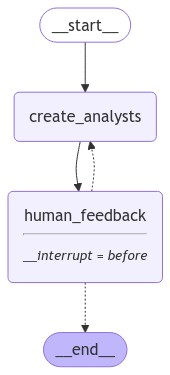

In [127]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Input
max_analysts = 3 
topic = "I am in a financial industry, I would like to conduct a a deep financial research on Apple"
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Sarah Thompson
Affiliation: Tech Investment Group
Role: Technology Trends Analyst
Description: Focuses on analyzing Apple's innovation strategies, product development, and technological advancements. Concerned with how these factors drive financial performance and market positioning.
--------------------------------------------------
Name: Michael Chen
Affiliation: Green Finance Advisors
Role: Sustainability and ESG Analyst
Description: Examines Apple's sustainability initiatives, environmental impact, and ESG (Environmental, Social, and Governance) practices. Motivated by understanding how these elements affect investor perceptions and long-term financial health.
--------------------------------------------------
Name: Emily Davis
Affiliation: Global Market Insights
Role: Market and Competitive Analyst
Description: Analyzes Apple's market share, competitive landscape, and global expansion strategies. Focuses on how these aspects influence Apple's revenue growth and competitive a

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from an investment banking to provide additional reseach and market insight"}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8357c-d36b-68f5-8002-999001d48368'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Sarah Thompson
Affiliation: Tech Investment Group
Role: Technology Trends Analyst
Description: Focuses on analyzing Apple's innovation strategies, product development, and technological advancements. Concerned with how these factors drive financial performance and market positioning.
--------------------------------------------------
Name: Michael Chen
Affiliation: Green Finance Advisors
Role: Sustainability and ESG Analyst
Description: Examines Apple's sustainability initiatives, environmental impact, and ESG (Environmental, Social, and Governance) practices. Motivated by understanding how these elements affect investor perceptions and long-term financial health.
--------------------------------------------------
Name: Emily Davis
Affiliation: Global Market Insights
Role: Market and Competitive Analyst
Description: Analyzes Apple's market share, competitive landscape, and global expansion strategies. Focuses on how these aspects influence Apple's revenue growth and competitive a

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef8357d-35cb-6f85-8004-9cc9b1abc6c5'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alice Chen
Affiliation: Tech Investment Firm
Role: Technology Analyst
Description: Focuses on Apple's technological innovations, product development, and competitive positioning in the tech industry. Concerned with how Apple's technology roadmap affects its market share and growth potential.
--------------------------------------------------
Name: David Lee
Affiliation: Global Market Research
Role: Market Analyst
Description: Analyzes Apple's market trends, consumer behavior, and global expansion strategies. Interested in how Apple's brand and marketing strategies influence its financial performance.
--------------------------------------------------
Name: Michael Johnson
Affiliation: Investment Banking
Role: Financial Analyst
Description: Provides insights into Apple's financial health, investment opportunities, and market valuation. Focused on Apple's financial statements, stock performance, and potential risks and rewards for investors.
----------------------------------------

## Conduct Interview

###  Generate Question 


The analyst will ask questions to the expert

In [128]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [129]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Tools

The expert will gather information from multiple sources in parallel to answer questions 

For example, we can use

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search (Google Search + Tavily) 
* Wikipedia search

#### Tavily

In [130]:
# Web search tool
web_search_tool = TavilySearchAPIRetriever(k=2)

#### Wikipedia 

In [132]:

from langchain_community.utilities.wikipedia import WikipediaAPIWrapper

#### Database Internal Search

In [133]:
index_name = 'nam-index'
indexes = [index_name] # we can add more indexes here if needed
agg_search_results = dict() # store retrieved results for each index


def get_search_results(query: str, indexes: list,
                       k: int = 5,
                       reranker_threshold: float = 1.2, # range between 0 and 4 (high to low)
                       sas_token: str = "") -> List[dict]:
    """Performs multi-index hybrid search and returns ordered dictionary with the combined results"""

    headers = {'Content-Type': 'application/json','api-key': os.environ["AZURE_SEARCH_KEY"]}
    params = {'api-version': os.environ['AZURE_SEARCH_API_VERSION']}

    agg_search_results = dict()

    for index in indexes:
        search_payload = {
            "search": query,
            "select": "id, title, chunk, name, location",
            "queryType": "semantic",
            "vectorQueries": [{"text": query, "fields": "chunkVector", "kind": "text", "k": k,
                                                                              "threshold":{
                                                    "kind": "vectorSimilarity",
                                                    "value": 0.5 # 0.333 - 1.00 (Cosine), 0 to 1 for Euclidean and DotProduct.
                }
                               }],
            "semanticConfiguration": "my-semantic-config", # change the name depends on your config name
            "captions": "extractive",
            "answers": "extractive",
            "count":"true",
            "top": k
        }

        resp = requests.post(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + index + "/docs/search",
                         data=json.dumps(search_payload), headers=headers, params=params)

        search_results = resp.json()
        agg_search_results[index] = search_results

    content = dict()
    ordered_content = OrderedDict()

    for index,search_results in agg_search_results.items():
        for result in search_results['value']:
            if result['@search.rerankerScore'] > reranker_threshold: # Range between 0 and 4
                content[result['id']]={
                                        "title": result['title'],
                                        "name": result['name'],
                                        "chunk": result['chunk'],
                                        "location": result['location'] + f'?{sas_token}' if result['location'] else "",
                                        "caption": result['@search.captions'][0]['text'],
                                        "score": result['@search.rerankerScore'],
                                        "index": index
                                    }


    topk = k

    count = 0  # To keep track of the number of results added
    for id in sorted(content, key=lambda x: content[x]["score"], reverse=True):
        ordered_content[id] = content[id]
        count += 1
        if count >= topk:  # Stop after adding topK results
            break

    return ordered_content

class CustomRetriever(BaseRetriever):
    topK: int
    reranker_threshold: float
    indexes: List
    sas_token: str = None

    """Modify the _get_relevant_documents methods in BaseRetriever so that it aligns with our previous settings
       Retrieved Documents are sorted based on reranker score (semantic score)
    """
    def _get_relevant_documents(self, query: str) -> List[Document]:

        ordered_results = get_search_results(query, self.indexes, k = self.topK,
                                             reranker_threshold = self.reranker_threshold,
                                             sas_token = self.sas_token)
        top_docs = []

        for key, value in ordered_results.items():
            location = value['location'] if value['location'] is not None else ""
            top_docs.append(Document(page_content=value['chunk'], metadata = {"source": location, 'score':value['score']}))

        return top_docs
# Initialize custom retriever on Azure AI Search
k=5
retriever = CustomRetriever(indexes=indexes, topK=k, reranker_threshold=1.2, sas_token=os.environ['BLOB_SAS_TOKEN'])



#### Google Search

We use serper to get google results https://serper.dev/api-key 

In [135]:
from langchain_community.utilities import GoogleSerperAPIWrapper
import pprint

In [136]:
google_search = GoogleSerperAPIWrapper(k = 3) # get 3 search results from google 


def ggsearch_reformat(result):
    documents = []
    
    try:
        # Check for knowledge graph
        if 'knowledgeGraph' in result:
            kg = result['knowledgeGraph']
            doc = Document(
                page_content=kg.get('description', ''),
                metadata={
                    'source': kg.get('descriptionLink', ''),
                    'title': kg.get('title', ''),
                }
            )
            documents.append(doc)
        
        # Check for organic results
        if 'organic' in result:
            for item in result['organic']:
                doc = Document(
                    page_content=item.get('snippet', ''),
                    metadata={
                        'source': item.get('link', ''),
                        'title': item.get('title', ''),
                    }
                )
                documents.append(doc)
        
        if not documents:
            raise ValueError("No search results found")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        documents.append(Document(
            page_content="No search results found or an error occurred.",
            metadata={'source': 'Error', 'title': 'Search Error'}
        ))
    
    return documents

    

In [137]:
ggsearch_reformat(google_search.results('What day is today'))

[Document(metadata={'source': 'https://nationaltoday.com/today/', 'title': 'What is Today? - National Today'}, page_content='October 6, 2024 - Today is \u200bNational Transfer Money to Your Daughter Day, World Cerebral Palsy Day, National Plus Size Appreciation Day, Mad Hatter Day, ...'),
 Document(metadata={'source': 'https://www.daysoftheyear.com/today/', 'title': 'What national day is today? | Days Of The Year'}, page_content="It's National Transfer Money to Your Daughter Day, National Coaches Day, National Physician Assistant Day, Change A Light Day, National Mad Hatter Day… and much ..."),
 Document(metadata={'source': 'https://www.calendarr.com/united-states/', 'title': 'Calendar (What Day is Celebrated Today?) - Calendarr'}, page_content='What day is it today? Today is Saturday, 05 October 2024. Day of the year: 279.')]

### Function nodes

We also create a node to answer analyst questions 

Finally, we will create nodes to save the full interview and to write summary section of the interview 

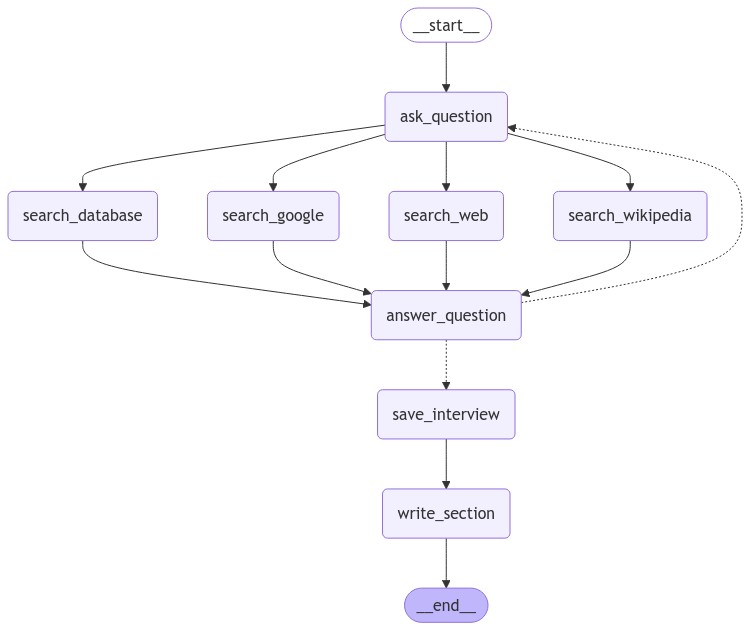

In [138]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = web_search_tool.invoke(search_query.search_query)

    return {"context": search_docs} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max= 4000).load(query = search_query.search_query)



    return {"context": search_docs} 


def search_google(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = ggsearch_reformat(google_search.results(search_query.search_query))
    
    return {"context": search_docs} 

def search_database(state: InterviewState):
    """ Retrieve docs from database """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # send query to azure ai search     
    search_docs = retriever.invoke(search_query.search_query)

    return {'context': search_docs} # ai search return in the format of list Document already



answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("search_google", search_google)
interview_builder.add_node("search_database", search_database)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("ask_question", "search_google")
interview_builder.add_edge("ask_question", "search_database")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_edge("search_google", "answer_question")
interview_builder.add_edge("search_database", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [86]:
# Pick one analyst
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Apple's Technological Innovations: Shaping the Future of the Tech Industry

### Summary

Apple continues to solidify its position as a leader in technological innovation, with a strategic focus on product development and competitive positioning. The company's roadmap for 2023-2024 highlights its commitment to maintaining market dominance and driving growth through cutting-edge advancements.

Apple's product roadmap includes significant updates and new releases that underline its ambition to push technological boundaries. Notably, the upcoming Vision Pro headset, expected in 2025, signifies Apple's foray into augmented reality (AR) and virtual reality (VR), areas that are increasingly pivotal in the tech landscape. This move is complemented by the introduction of the third-generation AirPods Pro and a revamped Apple TV, both of which feature enhanced specifications aimed at elevating user experience in audio and entertainment sectors [1].

In addition to hardware innovations, Apple is making strides in artificial intelligence (AI). The launch of Apple Intelligence, integrated into iOS 18, iPadOS 18, and macOS Sequoia, marks a bold entry into the AI arena. This system leverages Apple silicon to enhance language and image processing, offering features like generative AI across native apps. The emphasis on privacy with Private Cloud Compute sets Apple apart from competitors, ensuring user data security [2].

Apple's strategic focus on AI, coupled with a resilient iPhone market, positions the company for unprecedented growth. As it approaches a $4 trillion valuation, Apple's robust supply chain and continuous innovation underscore its potential for sustained dominance in the tech industry [3].

These developments are not only pivotal for Apple's market share but also for its growth potential. By integrating advanced technologies into its product lineup, Apple is poised to influence consumer preferences and set new standards in the industry. The company's ability to innovate while maintaining a strong market presence is a testament to its strategic foresight and execution.

### Sources

[1] https://news.techable.com/apple-new-devices-2023-2024/  
[2] https://www.apple.com/newsroom/2024/06/introducing-apple-intelligence-for-iphone-ipad-and-mac/  
[3] https://applemagazine.com/apple-on-the-brink-of-a-4-trillion-valuation-ai-innovations-strong-iphone-demand-lead-the-way/63068  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [139]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

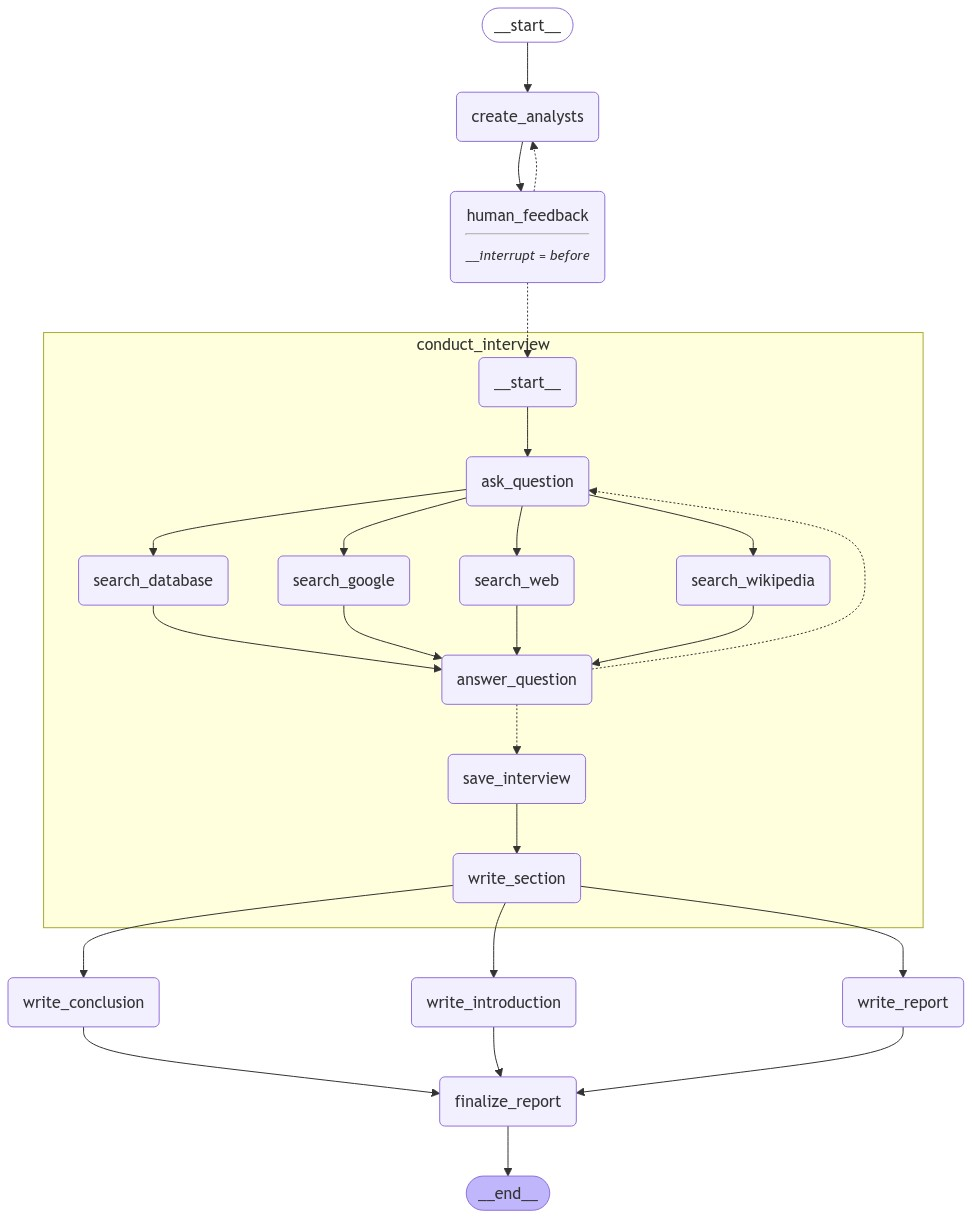

In [140]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm_writing.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm_writing.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm_writing.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [141]:
# Inputs
max_analysts = 3 
topic = "Conduct a financial research on Intel and provide a suggestion on whether I should invest in the company or not"
thread = {"configurable": {"thread_id": "9"}}

# Run the graph until the first interruption
print('Here is our current list of Analysts:')
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  


# get user input for the additional analyst 
human_analyst_feedback = input('Give me an analyst you would like to add to the crew:')

def check_user_input(human_feedback):
    return human_feedback or None
    
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                check_user_input(human_analyst_feedback)}, as_node="human_feedback")


# Check

print("#" * 100)
print('\n')

print('Revised list of analyst after the first human feedback')  
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  


# Confirm we are happy

human_analyst_feedback = input('Would you like to add any analyst? If not, press Enter to start the interview process: ')



graph.update_state(thread, {"human_analyst_feedback": 
                            check_user_input(human_analyst_feedback)}, as_node="human_feedback")


Here is our current list of Analysts:
Name: Alice Johnson
Affiliation: Tech Financial Insights
Role: Technology Analyst
Description: Focuses on Intel's technological advancements, product pipeline, and competitive positioning in the semiconductor industry. Concerned with innovation and R&D investments.
--------------------------------------------------
Name: Bob Smith
Affiliation: Market Dynamics Group
Role: Market Analyst
Description: Analyzes market trends, demand for Intel's products, and the company's market share. Interested in consumer behavior and industry competition.
--------------------------------------------------
Name: Carol Lee
Affiliation: Financial Strategies Inc.
Role: Financial Analyst
Description: Examines Intel's financial health, including revenue, profitability, and stock performance. Focuses on financial ratios, earnings reports, and investment potential.
--------------------------------------------------
##########################################################

{'configurable': {'thread_id': '9',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef83b2b-dc71-6ea7-8004-42470f54a31a'}}

In [142]:
print('Here is our 3 selected analysts:')
print('\n')
for analyst in graph.get_state(config=thread).values['analysts']:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)  
    

Here is our 3 selected analysts:


Name: Sophia Chen
Affiliation: TechMarket Insights
Role: Chip Industry Analyst
Description: Focuses on semiconductor market trends, competitive positioning, and technological advancements. Evaluates Intel's market share and innovation capabilities.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Financial Growth Advisors
Role: Financial Analyst
Description: Specializes in financial performance analysis, including revenue growth, profitability, and risk assessment. Analyzes Intel's financial health and investment potential.
--------------------------------------------------
Name: Raj Patel
Affiliation: EcoTech Strategies
Role: Sustainability Analyst
Description: Examines environmental and sustainability practices within the tech industry. Reviews Intel's sustainability initiatives and their impact on long-term growth.
--------------------------------------------------


Now let's conduct interview and generate report

In [143]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [144]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Investing in Intel: A Comprehensive Analysis

## Introduction

This report provides an in-depth analysis of Intel Corporation, focusing on its market leadership, financial performance, and sustainability initiatives. In the semiconductor industry, Intel has reclaimed its position as a market leader, showcasing resilience and innovation. Despite recent financial challenges, Intel's strategic focus on new technologies and operational efficiencies suggests potential for recovery and growth. Additionally, Intel's commitment to sustainability highlights its role in fostering a greener tech industry. By examining these aspects, this report aims to offer a well-rounded perspective on whether investing in Intel is a prudent decision.

---



Intel Corporation stands as a pivotal player in the semiconductor industry, demonstrating resilience and strategic acumen in reclaiming its market leadership. In 2023, Intel surpassed Samsung with a 9.1% share of the global semiconductor market, underscoring its competitive edge and innovative prowess [1][2]. The company's historical contributions, such as the x86 instruction sets and Intel Core CPUs, highlight its longstanding influence in high-performance computing [3]. Intel's ability to design and manufacture its own chips offers a significant advantage over competitors reliant on contract manufacturers [3].

Despite facing financial challenges, Intel's recent performance reveals a complex picture. The company's annual revenue for 2023 was $54.2 billion, reflecting a 14% decline from the previous year due to market dynamics and stiff competition from AMD and Nvidia [1][2]. However, a 10% year-over-year increase in fourth-quarter revenue, driven by new product launches like the Intel® Core™ mobile processor Series 1 family, indicates potential for recovery [2]. Intel's strategic focus on innovation and operational efficiencies aims to achieve mid- to high-single-digit revenue growth in the coming years, with a target of 10%-12% growth by 2026 [4][5].

Intel's commitment to sustainability further enhances its competitive position. The company has achieved 93% renewable electricity usage, saved 9.6 billion gallons of water, and upcycled 67% of its manufacturing waste [1]. Its focus on sustainable computing and eco-conscious manufacturing practices reflects a broader industry trend towards environmental responsibility [2]. Intel's Climate Transition Action Plan and partnerships aimed at grid decarbonization exemplify its dedication to systemic change and long-term growth [3].

In conclusion, Intel's market leadership, innovative capabilities, and sustainability initiatives position it well for future growth. While financial challenges persist, the company's strategic initiatives and commitment to sustainable practices provide a solid foundation for potential recovery and expansion. Investors should consider Intel's ability to execute its growth strategy and navigate the competitive landscape when evaluating investment opportunities.


---

## Conclusion

Intel's strategic positioning in the semiconductor industry, marked by its market leadership and innovation, underscores its resilience amid competitive pressures. Despite a notable decline in annual revenue, Intel's recent product launches and strategic focus on innovation suggest potential for recovery. The company's commitment to sustainability further enhances its long-term growth prospects, setting a benchmark for environmental responsibility in the tech industry. While challenges remain, Intel's robust market position and forward-looking strategies offer a promising outlook for investors. Careful monitoring of Intel's execution and market dynamics will be crucial for informed investment decisions.

## Sources

[1] https://www.statista.com/statistics/266143/global-market-share-of-leading-semiconductor-vendors/  
[2] https://www.statista.com/statistics/294804/semiconductor-revenue-of-intel-worldwide-market-share/  
[3] https://en.wikipedia.org/wiki/Intel  
[4] https://www.intel.com/content/www/us/en/newsroom/news/2023-intel-innovation-day-1-all-news.html  
[5] https://www.intel.com/content/www/us/en/newsroom/resources/intel-innovation-2023.html  
[6] https://www.macrotrends.net/stocks/charts/INTC/intel/revenue  
[7] https://finance.yahoo.com/news/intel-reports-fourth-quarter-full-210100155.html  
[8] https://www.intel.com/content/www/us/en/newsroom/news/intel-highlights-2022-long-term-growth-strategy-investor-meeting.html  
[9] https://www.intc.com/news-events/press-releases/detail/1637/intel-reports-second-quarter-2023-financial-results  
[10] https://www.intel.com/content/www/us/en/newsroom/news/top-takeaways-intel-corporate-responsibility-report-2024.html  
[11] https://www.intel.com/content/www/us/en/environment/sustainability.html  
[12] https://www.intel.com/content/www/us/en/environment/intel-and-the-environment.html